# lab zero

In [1]:
from contra_qa.text_generation.boolean2_S_and import boolean2
from contra_qa.train_functions.util import get_data, training_loop_text_classification # noqa
from contra_qa.train_functions.RNNConfig import RNNConfig
from contra_qa.train_functions.RNN import RNN
from contra_qa.train_functions.DataHolder import DataHolder
from contra_qa.plots.functions import plot_confusion_matrix
from contra_qa.text_processing.functions import simple_pre_process_text_df
import pandas as pd
import os
import torch
from torch.utils.data import TensorDataset
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

In [17]:
boolean2()

path_train = os.path.join("data",
                          "boolean2_train.csv")
path_test = os.path.join("data",
                         "boolean2_test.csv")

TEXT, LABEL, train, valid, test = get_data(path_train,
                                           path_test)

current_config = RNNConfig(vocab_size=len(TEXT.vocab),
                           output_dim=len(LABEL.vocab),
                           rnn_dim=296,
                           embedding_dim=252,
                           learning_rate=0.020,
                           momentum=0.655,
                           epochs=9)

current_data = DataHolder(current_config,
                              train,
                              valid,
                              test)

/home/felsal/Desktop/ContraQA/contra_qa/text_processing/functions.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[key] = data[key].apply(lambda x: x.lower())
/home/felsal/Desktop/ContraQA/contra_qa/text_processing/functions.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[key] = data[key].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x))) # noqa
/home/felsal/Desktop/ContraQA/contra_qa/text_processing/functions.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [18]:
def show_acc(model, batch_text, batch_label):
    pred = model.predict(batch_text)
    labels_legend = ['no', 'yes']
    plot_confusion_matrix(truth=batch_label.numpy(),
                          predictions=pred.numpy(),
                          save=True,
                          path="testRNN.png",
                          classes=labels_legend)

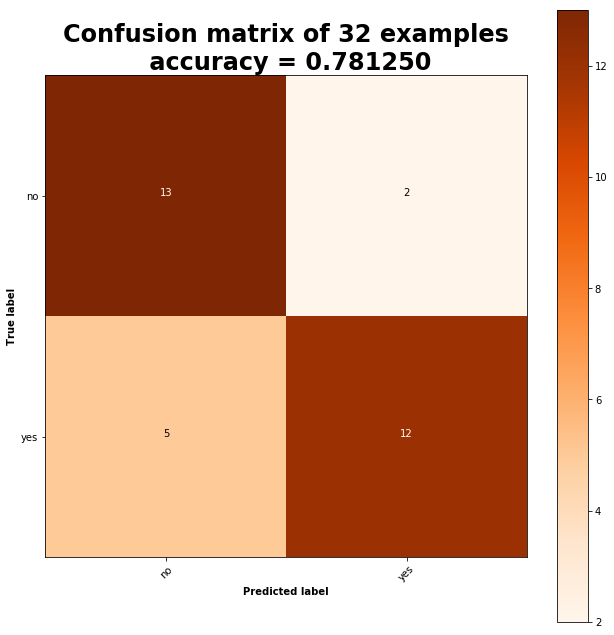

In [33]:
model = RNN(current_config)
model.load_state_dict(torch.load("RNN_boolean2_epochs_9_embedding_dim_252_rnn_dim_296_learning_rate_0p170_momentum_0p655.pkl"))

valid_batch = next(iter(current_data.valid_iter))
show_acc(model, valid_batch.text, valid_batch.label)

In [22]:
df2 = pd.read_csv("data/boolean2_train.csv")
df2test = pd.read_csv("data/boolean2_test.csv")

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]



def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)

In [23]:
exampleS1_train_t = str_list2tensor(list(df2train.sentence1.values))
exampleS2_train_t = str_list2tensor(list(df2train.sentence2.values))
exampleA_train_t = str_list2tensor(list(df2train.and_A.values))
exampleB_train_t = str_list2tensor(list(df2train.and_B.values))
exampleLabel_train = torch.tensor(list(df2train.label.values), dtype=torch.long, device=device)


exampleS1_valid_t = str_list2tensor(list(df2valid.sentence1.values))
exampleS2_valid_t = str_list2tensor(list(df2valid.sentence2.values))
exampleA_valid_t = str_list2tensor(list(df2valid.and_A.values))
exampleB_valid_t = str_list2tensor(list(df2valid.and_B.values))
exampleLabel_valid = torch.tensor(list(df2valid.label.values), dtype=torch.long, device=device)


exampleS1_test_t = str_list2tensor(list(df2test.sentence1.values))
exampleS2_test_t = str_list2tensor(list(df2test.sentence2.values))
exampleA_test_t = str_list2tensor(list(df2test.and_A.values))
exampleB_test_t = str_list2tensor(list(df2test.and_B.values))
exampleLabel_test = torch.tensor(list(df2test.label.values), dtype=torch.long, device=device)


train_dataset = TensorDataset(exampleS1_train_t, exampleS2_train_t, exampleA_train_t, exampleB_train_t, exampleLabel_train)
valid_dataset = TensorDataset(exampleS1_valid_t, exampleS2_valid_t, exampleA_valid_t, exampleB_valid_t, exampleLabel_valid)
test_dataset = TensorDataset(exampleS1_test_t, exampleS2_test_t, exampleA_test_t, exampleB_test_t, exampleLabel_test)

In [24]:
from torch.utils.data import DataLoader

class DataHolderALT():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [25]:
b_data = DataHolderALT(current_config,
                       train_dataset,
                       valid_dataset,
                       test_dataset)

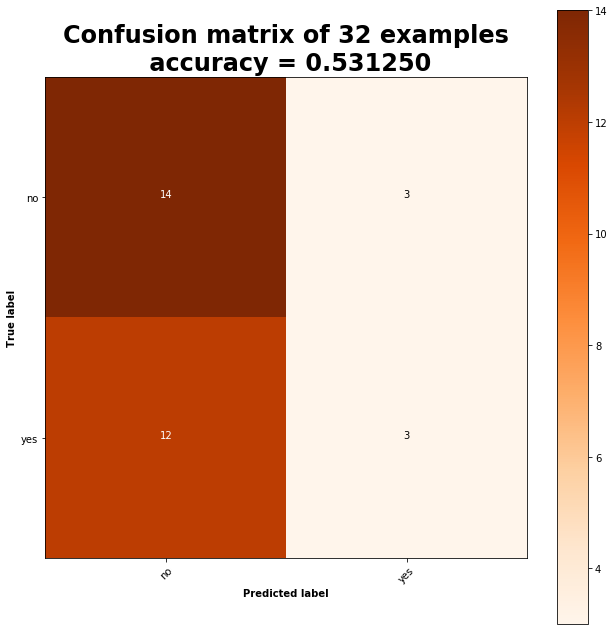

In [34]:
model = RNN(current_config)
model.load_state_dict(torch.load("RNN_boolean2_epochs_9_embedding_dim_252_rnn_dim_296_learning_rate_0p170_momentum_0p655.pkl"))


s1, s2, and_A, and_B, label = next(iter(b_data.valid_loader))
s = torch.cat([s1, s2], dim=1)
s = s.view((s.shape[1], s.shape[0]))
show_acc(model, s, label)